In [34]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import time
import re #정규식

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC #△3 :지연시간 대기를 위한 라이브러리

import matplotlib.pyplot as plt #그래프 라이브러리

from bs4 import BeautifulSoup
import requests



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-22-a4b0b5eb4958>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-22-a4b0b5eb4958>:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
<ipython-input-22-a4b0b5eb4958>:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
<ipython-input-22-a4b0b5eb4958>:17: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  every_time_content = driver.

시간별 기온
[('06', '-10'), ('07', '-10'), ('08', '-9'), ('09', '-7'), ('10', '-5'), ('11', '-2'), ('12', '0'), ('13', '1'), ('14', '1'), ('15', '2'), ('16', '1'), ('17', '1'), ('18', '0'), ('19', '-1'), ('20', '-3'), ('21', '-3'), ('22', '-4'), ('23', '-5'), ('00', '-5'), ('01', '-6'), ('02', '-6'), ('03', '-7'), ('04', '-7'), ('05', '-7')]
시간별 강수확률
[('06', '7'), ('07', '7'), ('08', '9'), ('09', '9'), ('10', '6'), ('11', '2'), ('12', '0'), ('13', '0'), ('14', '0'), ('15', '0'), ('16', '0'), ('17', '1'), ('18', '2'), ('19', '3'), ('20', '4'), ('21', '3'), ('22', '2'), ('23', '3'), ('00', '5'), ('01', '7'), ('02', '6'), ('03', '5'), ('04', '5'), ('05', '6')]


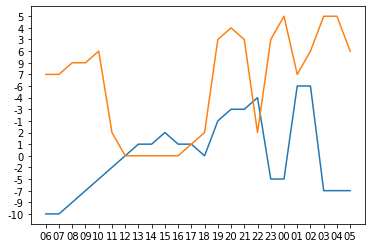

In [22]:
#BBC Weather 크롤링 주소 / 한국의 25개 지역을 영문으로 지원해줌.
#BBC Weather/ 시작페이지
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://www.bbc.com/weather")

#검색창에 도시명 검색
elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
elem.clear()
elem.send_keys("Seoul")
elem.send_keys(Keys.RETURN)
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "wr-time-slot-primary__hours")))
#도시명 입력하고 난 후
driver.execute_script("window.scrollTo(0, 200)")
elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
elem.click() #클릭

every_time_content = driver.find_elements_by_class_name("wr-time-slot-primary__hours") #매 시간을 리스트로 받아온다.
bbc_time = list()
for i in every_time_content:
    time = i.text
    bbc_time.append(time)
every_temp = driver.find_elements_by_css_selector(".wr-temperature--time-slot > .wr-value--temperature--c")
bbc_temp = list() #모든 온도를 받을 리스트
for i in every_temp:
    temp = i.text.replace("°", "")
    bbc_temp.append(temp)
every_PP = driver.find_elements_by_css_selector(".wr-time-slot-primary__precipitation > .wr-u-font-weight-500")
bbc_precip = list() #모든 강수확률을 받을 리스트
for i in every_PP:
    precip = i.text.replace("%", "")
    precip = precip.replace("chance of precipitation", "")
    precip = precip.replace('\n', '')
    bbc_precip.append(precip)
    
bbc_temp_per_time = list() #(시간, 기온)형태의 리스트
bbc_precip_per_time = list() # (시간, 강수확률) 형태의 리스트
for i in zip(bbc_time, bbc_temp):
    bbc_temp_per_time.append(i)
for i in zip(bbc_time, bbc_precip):
    bbc_precip_per_time.append(i)
print("시간별 기온")
print(bbc_temp_per_time)
print("시간별 강수확률")
print(bbc_precip_per_time)
#그래프 그리기
plt.plot(bbc_time, bbc_temp)
plt.plot(bbc_time, bbc_precip)
plt.show()

In [37]:
driver.get("https://weather.naver.com/")
kma_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.kma > button")
kma_button[0].click()
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
driver.execute_script("window.scrollTo(0, 400)")

kma_temp = list()
kma_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
kma_time_list = list()

kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i == 28):
        break;
    if (i % 2 == 0): 
        kma_time_list.append(data.text)
    if (i % 2 == 1):
        kma_temp.append(data.text)
        
for i, data in enumerate(kma_precip_raw):
    if (i == 14):
        break;
    kma_precip.append(data.text)
        
    
next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(1.5)
kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i < 28):
        pass
    elif (i == 56):
        break
    elif (i % 2 == 0): 
        kma_time_list.append(data.text)
    elif (i % 2 == 1):
        kma_temp.append(data.text)

for i, data in enumerate(kma_precip_raw):
    if (i < 14):
        pass
    elif (i == 28):
        break
    else:
        kma_precip.append(data.text)


next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i < 56):
        pass
    elif (i == 84):
        break
    elif (i % 2 == 0): 
        kma_time_list.append(data.text)
        #print(i, data.text)
    elif (i % 2 == 1):
        kma_temp.append(data.text)
        #print(i, data.text)
        
for i, data in enumerate(kma_precip_raw):
    if (i < 28):
        pass
    elif (i == 42):
        break
    else:
        kma_precip.append(data.text)
print(kma_precip)

#모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
kma_temp_data = zip(kma_time_list, kma_temp)
kma_precip_data = zip(kma_time_list, kma_precip)
#
#for i in accu_data:
#    print(i)
#
switch = 0
kma_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
kma_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
kma_tomorrow_precip_list = list() #강수확률 데이터
for zipped_data in kma_temp_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        kma_tomorrow_temp_list.append(zipped_data)
        
for zipped_data in kma_precip_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        kma_tomorrow_precip_list.append(zipped_data)
print("내일 기상청 24시간 기온")
print(kma_tomorrow_temp_list)
print("내일 기상청 24시간 강수")
print(kma_tomorrow_precip_list)

<ipython-input-37-609029a5e4dd>:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  kma_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.kma > button")
<ipython-input-37-609029a5e4dd>:12: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
<ipython-input-37-609029a5e4dd>:13: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
<ipython-input-37-609029a5e4dd>:28: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  next_btn = dri

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '']
내일 기상청 24시간 기온
[('0시', '-7도'), ('1시', '-7도'), ('2시', '-7도'), ('3시', '-7도'), ('4시', '-7도'), ('5시', '-7도'), ('6시', '-7도'), ('7시', '-6도'), ('8시', '-7도'), ('9시', '-5도'), ('10시', '-3도'), ('11시', '-2도'), ('12시', '-1도'), ('13시', '0도'), ('14시', '1도'), ('15시', '1도'), ('16시', '2도'), ('17시', '1도'), ('18시', '-1도'), ('19시', '-2도'), ('20시', '-2도'), ('21시', '-3도'), ('22시', '-3도'), ('23시', '-4도')]
내일 기상청 24시간 강수
[('0시', '0'), ('1시', '0'), ('2시', '0'), ('3시', '0'), ('4시', '0'), ('5시', '0'), ('6시', '0'), ('7시', '0'), ('8시', '0'), ('9시', '0'), ('10시', '0'), ('11시', '0'), ('12시', '0'), ('13시', '0'), ('14시', '0'), ('15시', '0'), ('16시', '0'), ('17시', '0'), ('18시', '0'), ('19시', '0'), ('20시', '0'), ('21시', '0'), ('22시', '0'), ('23시', '0')]


In [38]:
#네이버 날씨(기상청 + 아큐웨더 + 웨더채널)
#driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://weather.naver.com/")
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
accu_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.accuweather > button")
print(len(accu_button))
accu_button[0].click()
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
time.sleep(2)
driver.execute_script("window.scrollTo(0, 400)")
accu_temp = list()
accu_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
accu_time_list = list()

accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")

for i, data in enumerate(accu_raw):
    if (i == 28):
        break;
    if (i % 2 == 0): 
        accu_time_list.append(data.text)
    if (i % 2 == 1):
        accu_temp.append(data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i == 14):
        break;
    accu_precip.append(data.text)
        
    
next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 28):
        pass
    elif (i == 56):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)

for i, data in enumerate(accu_precip_raw):
    if (i < 14):
        pass
    elif (i == 28):
        break
    else:
        accu_precip.append(data.text)


next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 56):
        pass
    elif (i == 84):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
        #print(i, data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)
        #print(i, data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i < 28):
        pass
    elif (i == 42):
        break
    else:
        accu_precip.append(data.text)
print(accu_precip)

#모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
accu_temp_data = zip(accu_time_list, accu_temp)
accu_precip_data = zip(accu_time_list, accu_precip)
#
#for i in accu_data:
#    print(i)
#
switch = 0
accu_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
accu_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
accu_tomorrow_precip_list = list() #강수확률 데이터
for zipped_data in accu_temp_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_temp_list.append(zipped_data)
        
for zipped_data in accu_precip_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_precip_list.append(zipped_data)
print("내일 24시간 기온")
print(accu_tomorrow_temp_list)
print("내일 24시간 강수")
print(accu_tomorrow_precip_list)

driver.execute_script("window.scrollTo(400, 0)")
######################################################################
#기상청 페이지로 넘어간다.


<ipython-input-38-c2b5c7f1f16f>:5: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.accuweather > button")


1


<ipython-input-38-c2b5c7f1f16f>:15: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
<ipython-input-38-c2b5c7f1f16f>:16: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
<ipython-input-38-c2b5c7f1f16f>:32: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
<ipython-input-38-c2b5c7f1f16f>:35: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() inst

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '']
내일 24시간 기온
[('0시', '-9도'), ('1시', '-10도'), ('2시', '-10도'), ('3시', '-10도'), ('4시', '-10도'), ('5시', '-10도'), ('6시', '-10도'), ('7시', '-11도'), ('8시', '-10도'), ('9시', '-9도'), ('10시', '-6도'), ('11시', '-3도'), ('12시', '-2도'), ('13시', '0도'), ('14시', '0도'), ('15시', '0도'), ('16시', '0도'), ('17시', '-1도'), ('18시', '-2도'), ('19시', '-4도'), ('20시', '-6도'), ('21시', '-7도'), ('22시', '-8도'), ('23시', '-9도')]
내일 24시간 강수
[('0시', '0'), ('1시', '0'), ('2시', '0'), ('3시', '0'), ('4시', '0'), ('5시', '0'), ('6시', '0'), ('7시', '0'), ('8시', '0'), ('9시', '0'), ('10시', '0'), ('11시', '0'), ('12시', '0'), ('13시', '0'), ('14시', '0'), ('15시', '0'), ('16시', '0'), ('17시', '0'), ('18시', '0'), ('19시', '0'), ('20시', '0'), ('21시', '0'), ('22시', '0'), ('23시', '0')]


In [33]:
print(dir(time))

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmod__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'capitalize', 'casefold', 'center', 'count', 'encode', 'endswith', 'expandtabs', 'find', 'format', 'format_map', 'index', 'isalnum', 'isalpha', 'isascii', 'isdecimal', 'isdigit', 'isidentifier', 'islower', 'isnumeric', 'isprintable', 'isspace', 'istitle', 'isupper', 'join', 'ljust', 'lower', 'lstrip', 'maketrans', 'partition', 'replace', 'rfind', 'rindex', 'rjust', 'rpartition', 'rsplit', 'rstrip', 'split', 'splitlines', 'startswith', 'strip', 'swapcase', 'title', 'translate', 'upper', 'zfill']
